In [244]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from scipy import stats # needed for ks test

from MAPseq_processing import * # import all functions from this script
from MAPseq_plotting import * # import all functions from this script

# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False

plt.rcParams['svg.fonttype'] = 'none'

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp
# specify blue/orange colors for qualitative intervals/data
blue_qual = [blue_cmp.colors[50], blue_cmp.colors[100], blue_cmp.colors[150], blue_cmp.colors[200], blue_cmp.colors[250]]
orange_qual = [orange_cmp.colors[36], orange_cmp.colors[72], orange_cmp.colors[108], orange_cmp.colors[144], orange_cmp.colors[180], orange_cmp.colors[216], orange_cmp.colors[252]]


In [131]:
# load data
# set-up paths
home_dir = '/Volumes/Data/'
# home_dir = "/mnt/labNAS/"


in_path = home_dir+'Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = home_dir+'Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

# Raw count data - apply threshold, areas remain seperated
with open(in_path + 'M194_M220_OMC_separate_count4.pkl', 'rb') as f:
    omc_count = pickle.load(f)

# Load binarized data - apply threshold for bins
with open(in_path + 'M194_M220_OMC_separate_bin4.pkl', 'rb') as f:
    omc_bin = pickle.load(f)
    
# with open(in_path + 'M194_M220_ACA_separate_all_count.pkl', 'rb') as f:
#     aca_count = pickle.load(f)

# normalized count data - threshold = 4
with open(in_path + 'M194_M220_OMC_separate_countN4.pkl', 'rb') as f:
    omc_countN = pickle.load(f)
    
# with open(in_path + 'M194_M220_ACA_separate_all_countN.pkl', 'rb') as f:
#     aca_countN = pickle.load(f)

In [132]:
plot_areas = ['AOMCi', 'POMCi','AOMCc', 'POMCc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'HIP', 'AMY', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']
omc_countN_cdf, foo = dfs_to_cdf(omc_countN, plot_areas=plot_areas)
omc_countN_cdf

# Normalize by median(s)

In [133]:
# Calculate median BC to possibly use for batch correction (across all target regions)
targets = ['AOMCc', 'POMCc', 'ACAc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']

medians = pd.DataFrame(columns=["AOMCi_med", "POMCi_med", "inj_med", "target_med", "all_med",
                                "mice", "species", "dataset"])


for i in range(metadata.shape[0]):
    df = omc_countN[i]

    # take nonzero median
#     aomci_df = df[df['inj_site']=="AOMCi"]
#     aomci = aomci_df["AOMCi"]
    aomci = df["AOMCi"]
    aomci = aomci[aomci!=0]
    aomci_med = aomci.median()

#     pomci_df = df[df['inj_site']=="POMCi"]
#     pomci = pomci_df["POMCi"]
    pomci = df["POMCi"]
    pomci = pomci[pomci!=0]
    pomci_med = pomci.median()

    # combine AOMCi and POMCi countN for inj_med
    inj_bc = pd.concat([aomci, pomci])
    inj_med = inj_bc.median()

    # calculate median from just nonzero countN in target sites
    target_bcN = pd.Series(dtype="float64")
    
    for area in targets:
       area_bc = df[area]
       area_bc = area_bc[area_bc!=0]
       target_bcN = pd.concat([target_bcN, area_bc])

    # calculate median of nonzero countN across whole brain
#     val_df = df.drop(["inj_site"], axis=1)
#     vals = val_df.values.flatten()
    vals = df.values.flatten()
    vals = vals[vals!=0]
    vals = vals[~np.isnan(vals)] # drop nans
    all_med = np.median(vals)
    
    target_med = target_bcN.median()

    row = [aomci_med, pomci_med, inj_med, target_med, all_med, 
           metadata.loc[i,"mice"], metadata.loc[i,"species"], metadata.loc[i,"dataset"]]

    medians.loc[i,:] = row

medians

,AOMCi_med,POMCi_med,inj_med,target_med,all_med,mice,species,dataset
0,0.00174,0.005713,0.004398,0.003253,0.003532,MMM1,MMus,M194
1,0.003976,0.003093,0.00355,0.002798,0.002956,MMF2,MMus,M194
2,0.000958,0.00781,0.005794,0.003036,0.003623,MMF3,MMus,M194
3,0.016377,0.001195,0.009528,0.003766,0.004306,STM1,STeg,M194
4,0.023111,0.000185,0.011657,0.004075,0.004587,STM2,STeg,M194
5,0.017352,0.000825,0.007085,0.003796,0.004203,STF3,STeg,M194
6,0.04291,0.044184,0.043883,0.092,0.079351,MMM4,MMus,M220
7,0.023609,0.028841,0.026688,0.089641,0.069024,MMF5,MMus,M220
8,0.101646,0.06219,0.080183,0.091397,0.08759,STF4,STeg,M220
9,0.098762,0.01308,0.035221,0.139175,0.112051,STM5,STeg,M220


In [183]:
to_plot = ['OMCi', 'OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 
           'SCm', 'PG', 'PAG', 'RN']
to_drop = ['OB', 'ACAi', 'ACAc', 'HIP', 'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl']

# combine areas
omc_countN_comb = df_combine_areas(omc_countN, to_drop=to_drop)
omc_bin_comb = df_combine_areas(omc_bin, to_drop=['OB', 'ACAi', 'ACAc', 'HIP'],
                                rename={"RN":"BS"})

# normalize by all barcodes median
omc_countN_med = []
for i in range(len(omc_countN_comb)):
    df = omc_countN_comb[i].copy()
    # df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "all_med"]
    omc_countN_med.append(df_m)

# normalize by inj barcodes median
omc_countN_med_inj = []
for i in range(len(omc_countN_comb)):
    df = omc_countN_comb[i].copy()
    # df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "inj_med"]
    omc_countN_med_inj.append(df_m)

# apply cell type to median inj normalized
cell_types = [sort_by_celltype(df, sort=False) for df in omc_bin_comb]
for i in range(metadata.shape[0]):
    omc_countN_med_inj[i]["type"] = cell_types[i]["type"]

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_th['type'] = "CT"
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_nth['type'] = "IT"
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [184]:
# seperate by cell types
all_types = omc_countN_med_inj.copy()
it_types = [df[df["type"]=="IT"] for df in omc_countN_med_inj]
pt_types = [df[df["type"]=="PT"] for df in omc_countN_med_inj]

# plot example CDF
- plotted STF6, as this is the animal used in the exmaple heatmap


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:709: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:739: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


0.49999999999999994


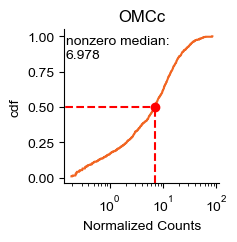

In [245]:
# calculate ecdf per animal and put into dataframe
area = "OMCc"
i=10 # 10 = STF6
cdf_df, ecdf_df = dfs_to_cdf([omc_countN_med_inj[i]], plot_areas=["OMCc"], 
                         metadata=metadata.loc[i:i].reset_index(drop=True))

ecdf = ecdf_df["STF6_OMCc"]

# calculate median on nonzero values to plot
df = omc_countN_med_inj[i]
area_bc = df[area]
vals = area_bc.values.flatten()
n0_idx = np.nonzero(vals)
n0 = vals[n0_idx]
n0_median = np.median(n0)

print(ecdf(n0_median))

# plot
sns.lineplot(cdf_df, x="x", y="cdf", estimator=None,
              color=orange_cmp.colors[255]) # plots individual mice

# get rid of top and right axis
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xscale("log")
plt.xlabel("Normalized Counts")
plt.title(area)

# horizontal line through 0.5
plt.hlines(y=0.5, xmin=0, xmax=n0_median, colors="red", linestyles="--")
# plot vertical line through non-zero median
plt.axvline(x=n0_median, ymin=0, ymax=0.49, color="red", linestyle="--")
# print median so can label in illustrator
plt.text(0.15, 0.85, "nonzero median:\n"+str(round(n0_median,3)))
# plot point at median
plt.plot(n0_median, 0.5, 'ro')

# set figure size
fig_size=(2,2)
fig = plt.gcf()
fig.set_size_inches(fig_size[0],fig_size[1])

# savefig
plt.savefig(out_path+"ex_stf6_omcc_cdf_labelled.svg", dpi=300, bbox_inches="tight")

plt.show()

# Plot CDFs

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


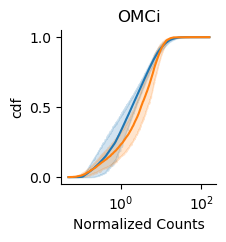

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


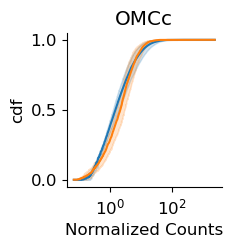

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


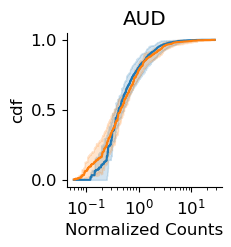

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


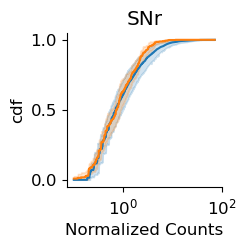

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


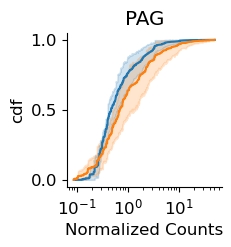

In [12]:
# all cell types - NORMALIZED TO ALL MEDIAN

plot_ind = [["OMCi"], ["OMCc"], ["AUD"], ["SNr"], ["PAG"]]
labels = ["OMCi", "OMCc", "AUD", "SNr", "PAG"]

# NOTE: USED COUNTS NORMALIZED BY INJECTION SITE MEDIAN

# plot OMCi, OMCc, AUD, PAG, SNr seperately
for i in range(len(plot_ind)):
    area = plot_ind[i]
    plot_cdf(omc_countN_med, plot_areas=area, color_by="species", title=None, legend=False, 
             individual=False, fig_size=(2,2))
    # plt.savefig(out_path+"cdf_comb_all_med_"+labels[i]+"_mean_ci95_all.svg", dpi=300, bbox_inches="tight")
    plt.show()


In [14]:
all_types[0].columns

Index(['OMCi', 'OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'PAG', 'SNr', 'SCm',
       'PG', 'RN', 'type'],
      dtype='object')

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


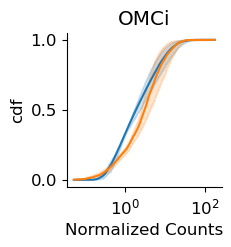

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


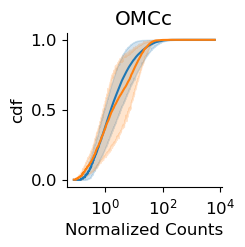

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


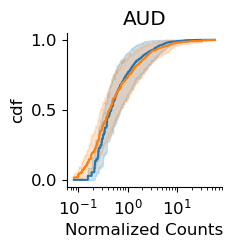

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


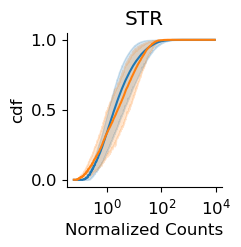

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


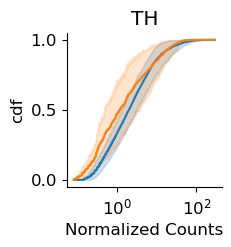

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


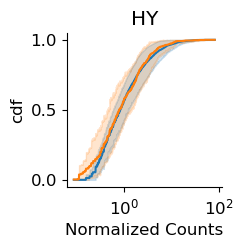

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


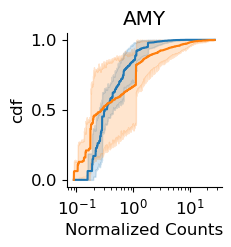

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


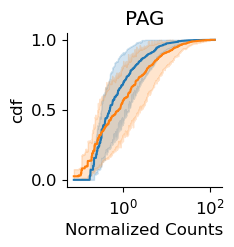

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


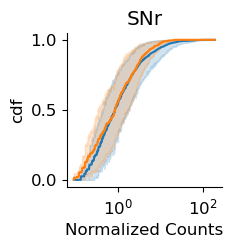

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


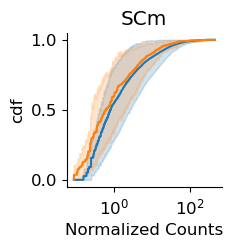

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


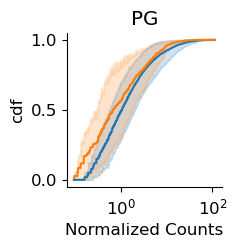

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


NO BARCODES, cannot compute ECDF for RN STM2


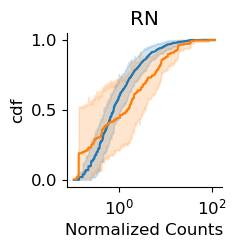

In [15]:
# all cell types

plot_ind = [['OMCi'], ['OMCc'], ['AUD'], ['STR'], ['TH'], ['HY'], ['AMY'], ['PAG'], 
            ['SNr'], ['SCm'],['PG'], ['RN']]
labels = ['OMCi', 'OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'PAG', 'SNr', 'SCm',
       'PG', 'RN']

# NOTE: USED COUNTS NORMALIZED BY INJECTION SITE MEDIAN

# plot OMCi, OMCc, AUD, PAG, SNr seperately
for i in range(len(plot_ind)):
    area = plot_ind[i]
    plot_cdf(all_types, plot_areas=area, color_by="species", title=None, legend=False, 
             individual=False, fig_size=(2,2))
    plt.savefig(out_path+"cdf_comb_all_med_"+labels[i]+"_mean_ci95_all.svg", dpi=300, bbox_inches="tight")
    plt.show()


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


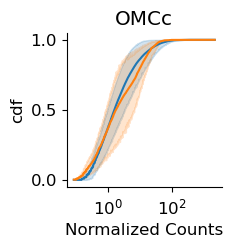

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


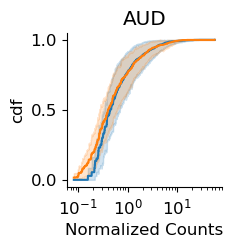

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


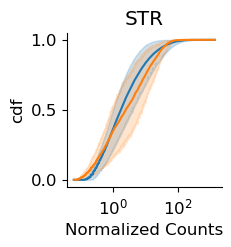

In [16]:
# plot by cell types - IT
plot_ind = [['OMCc'], ['AUD'], ['STR']]
labels = ['OMCc', 'AUD', 'STR']

# NOTE: USED COUNTS NORMALIZED BY INJECTION SITE MEDIAN

# plot OMCi, OMCc, AUD, PAG, SNr seperately
for i in range(len(plot_ind)):
    area = plot_ind[i]
    plot_cdf(it_types, plot_areas=area, color_by="species", title=None, 
             legend=False, individual=False, fig_size=(2,2))
    plt.savefig(out_path+"cdf_comb_all_med_"+labels[i]+"_mean_ci95_it.svg", dpi=300, bbox_inches="tight")
    plt.show()


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


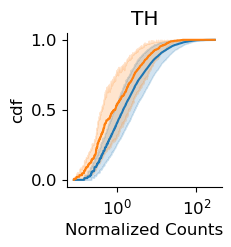

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


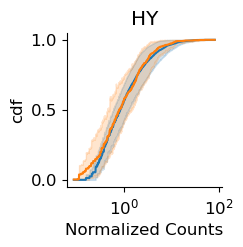

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


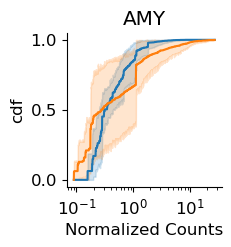

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


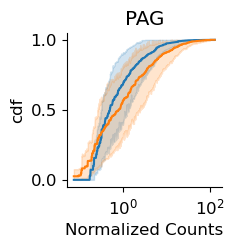

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


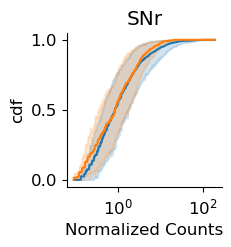

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


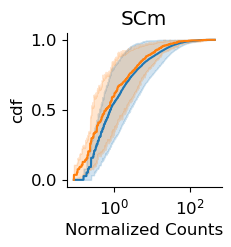

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


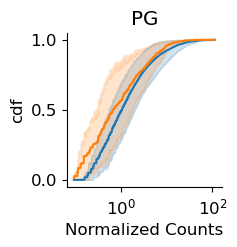

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:699: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:729: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


NO BARCODES, cannot compute ECDF for RN STM2


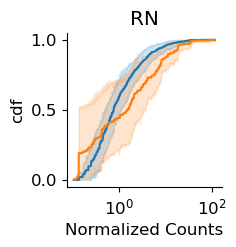

In [17]:
# plot by cell types - PT
plot_ind = [['TH'], ['HY'], ['AMY'], ['PAG'], ['SNr'], ['SCm'],['PG'], ['RN']]
labels = ['TH', 'HY', 'AMY', 'PAG', 'SNr', 'SCm',
       'PG', 'RN']

# NOTE: USED COUNTS NORMALIZED BY INJECTION SITE MEDIAN

# plot OMCi, OMCc, AUD, PAG, SNr seperately
for i in range(len(plot_ind)):
    area = plot_ind[i]
    plot_cdf(pt_types, plot_areas=area, color_by="species", title=None, 
             legend=False, individual=False, fig_size=(2,2))
    plt.savefig(out_path+"cdf_comb_all_med_"+labels[i]+"_mean_ci95_pt.svg", dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
# #### AUD VS PAG SCATTER ##########
# # calculate median
# meds_aud_pag = metadata.copy()
# aud_med = []
# pag_med = []

# for i in range(metadata.shape[0]):
#     df = omc_countN_med_inj[i]
#     # get area specific values
#     # drop zeros

#     aud_med = df['AUD'].replace(0,np.NaN).median()
#     pag_med = df['PAG'].replace(0,np.NaN).median()
#     meds_aud_pag.loc[i,'aud_med'] = aud_med
#     meds_aud_pag.loc[i,'pag_med'] = pag_med

# display(meds_aud_pag)

# sns.scatterplot(meds_aud_pag, x="aud_med", y="pag_med", hue="species",
#                 s=100)
# plt.xlabel("AUD BC/neuron median (normalized)")
# plt.ylabel("PAG BC/neuron median (normalized)")
# # plt.savefig(out_path+"omc_norm_med_AUDvPAG.svg", dpi=300, bbox_inches="tight")

In [ ]:
# # scatter and volcano
# # normalize by all BC median


# # to_drop = ['OB', 'AOMCi', 'POMCi', 'ACAi', 'ACAc', 'HIP', 'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl']
# plot_med = dfs_to_medians(omc_countN_med, drop=[])
# stvmm_area_scatter(plot_med, to_plot="median", log=True, title="all_med normed, BC/Neuron", line_up_limit=10)
# plt.savefig(out_path+"scatter_comb_all_med.jpg", dpi=200, bbox_inches="tight")
# plt.show()


# plot medians as dot plots

In [ ]:
plot_med = dfs_to_medians(omc_countN_med_inj, drop=["type"])
for area in plot_med['area'].unique():
    dot_plot(plot_med, area=area, title=area, to_plot="median")
    plt.ylabel("Normalized BC/neuron Median")
    plt.savefig(out_path+"median_"+area+"dotplot_all.svg", dpi=300, bbox_inches="tight")

    plt.show()

In [ ]:
plot_med = dfs_to_medians(it_types, drop=["type"])
to_plot = ["OMCc", "AUD"]
for area in to_plot:
    dot_plot(plot_med, area=area, title=area, to_plot="median")
    plt.ylabel("Normalized BC/neuron Median")
    plt.savefig(out_path+"median_"+area+"dotplot_it.svg", dpi=300, bbox_inches="tight")

    plt.show()

In [ ]:
plot_med = dfs_to_medians(pt_types, drop=["type"])
to_plot = ["PAG", "SNr"]
for area in to_plot:
    dot_plot(plot_med, area=area, title=area, to_plot="median")
    plt.ylabel("Normalized BC/neuron Median")
    plt.savefig(out_path+"median_"+area+"dotplot_pt.svg", dpi=300, bbox_inches="tight")

    plt.show()

# scatter and volcano
- can only compare 2 samples at a time w/ KS
- decided to look at median per area so can compare across groups

In [ ]:
# all bcs, no cell type separation
plot_med = dfs_to_medians(omc_countN_med_inj, drop=["type"])
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, p_01=False, title="OMC - inj normed - BC/neuron median - all types", 
             xlim=(-5,5), fig_size=(4.5,4.5))

plt.savefig(out_path+"volcano_comb_inj_med_all.svg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
it_med = dfs_to_medians(it_types, drop=["OMCi", "type"])
it_med['type'] = "IT"
pt_med = dfs_to_medians(pt_types, drop=["OMCi", "type"])
pt_med['type'] = "PT"
all_med = pd.concat([it_med, pt_med]).dropna().reset_index(drop=True)
# all_med.tail(10)

In [ ]:
# volcano
# plot_med = dfs_to_medians(omc_countN_med_inj, drop=["OMCi", "type"])
plot = stvmm_calc_ttest(all_med, sp1="MMus", sp2="STeg", to_plot="median")
plot_volcano(plot, p_01=False, shape="type", title="OMC - inj normed - BC/neuron median - cell types", 
             xlim=(-5,5), fig_size=(4.5,4.5))

plt.savefig(out_path+"volcano_comb_inj_med_celltypes.svg", dpi=300, bbox_inches="tight")
plt.show()